# import lib

In [1]:
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary
from tqdm import tqdm

# define a hyperparameters

In [3]:
args = {
    'train_path': '/kaggle/input/digit-recognizer/train.csv',
    'test_path': '/kaggle/input/digit-recognizer/test.csv',
    'submission':'/kaggle/input/digit-recognizer/sample_submission.csv',
    
    'epochs': 40,
    'lr': 2e-5,
    'batch_size':256
}

# check the sample dataset

In [4]:
train_data = pd.read_csv(args['train_path'])
test_data = pd.read_csv(args['test_path'])

label:1


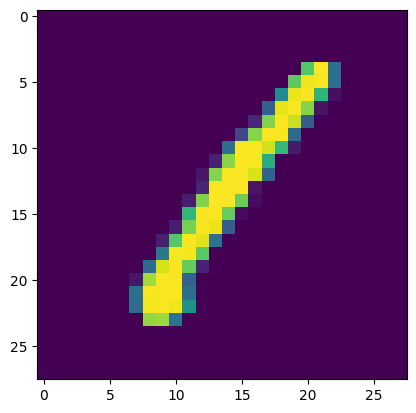

In [5]:
sample_label = train_data.loc[0,:].iloc[0]
print(f"label:{sample_label}")
img_list = train_data.loc[0,:][1:].values
img_tensor = torch.tensor(img_list).reshape(28,28)
plt.imshow(img_tensor)

# preprocessing

In [6]:
train_data.shape, type(train_data), test_data.shape, type(test_data)

((42000, 785),
 pandas.core.frame.DataFrame,
 (28000, 784),
 pandas.core.frame.DataFrame)

In [7]:
#separate label from img data
train_label = train_data['label']
train_data = train_data.drop(axis=1, columns='label')
train_label

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

In [8]:
train_data

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
valid_ratio = 0.1
split_idx = int(len(train_data)*(1.0-valid_ratio))

valid_data = train_data[split_idx:]
train_data = train_data[:split_idx]

valid_label = train_label[split_idx:]
train_label = train_label[:split_idx]

len(train_data), len(valid_data), len(train_label), len(valid_label)

(37800, 4200, 37800, 4200)

In [10]:
train_data = torch.tensor(train_data.values, dtype=torch.float32).reshape(-1,28,28)
valid_data = torch.tensor(valid_data.values, dtype=torch.float32).reshape(-1,28,28)

train_label = torch.tensor(train_label.values)
valid_label = torch.tensor(valid_label.values)

test_data = torch.tensor(test_data.values, dtype=torch.float32).reshape(-1,28,28)

In [11]:
train_dataset = TensorDataset(train_data, train_label)
valid_dataset = TensorDataset(valid_data, valid_label)
test_dataset = TensorDataset(test_data)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=args['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [13]:
for train_sample in train_loader:
    print(train_sample[0].shape, train_sample[1].shape)
    break

torch.Size([256, 28, 28]) torch.Size([256])


# model definition

In [14]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        """
        input shape : batch * 28 * 28
        """
        
        self.features = nn.Sequential(
            # 28 -> 14 / default stride = 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=32 ,out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # 14 -> 7
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=64 ,out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # 7 -> 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=128 ,out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(128,num_classes)
        )
        
    def __call__(self, x):
        x=x.unsqueeze(1)
        x = self.features(x)
        x = self.classifier(x)
        return x

In [15]:
model = Model(num_classes=10)

summary(model, (20,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [20, 128, 3, 3]           --
│    └─Conv2d: 2-1                       [20, 32, 28, 28]          320
│    └─Conv2d: 2-2                       [20, 32, 28, 28]          9,248
│    └─BatchNorm2d: 2-3                  [20, 32, 28, 28]          64
│    └─ReLU: 2-4                         [20, 32, 28, 28]          --
│    └─MaxPool2d: 2-5                    [20, 32, 14, 14]          --
│    └─Conv2d: 2-6                       [20, 64, 14, 14]          18,496
│    └─Conv2d: 2-7                       [20, 64, 14, 14]          36,928
│    └─BatchNorm2d: 2-8                  [20, 64, 14, 14]          128
│    └─ReLU: 2-9                         [20, 64, 14, 14]          --
│    └─MaxPool2d: 2-10                   [20, 64, 7, 7]            --
│    └─Conv2d: 2-11                      [20, 128, 7, 7]           73,856
│    └─Conv2d: 2-12                      [20, 128, 7, 7]           1

# Training

In [16]:
num_epochs = args['epochs']
optimizer = torch.optim.Adam(params=model.parameters(), lr=args['lr'], weight_decay=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

100%|██████████| 17/17 [00:03<00:00,  4.98it/s]


epoch:1
train_loss: 0.0066209500996524066, train_acc: 0.5774867724867725
valid_loss: 0.004582509625525702, valid_acc: 0.844047619047619


100%|██████████| 17/17 [00:03<00:00,  4.94it/s]


epoch:2
train_loss: 0.0031953220834177007, train_acc: 0.9033068783068783
valid_loss: 0.002457189488978613, valid_acc: 0.9226190476190477


100%|██████████| 17/17 [00:03<00:00,  4.99it/s]


epoch:3
train_loss: 0.0018583599071969432, train_acc: 0.9454232804232804
valid_loss: 0.0016241675473394849, valid_acc: 0.9528571428571428


100%|██████████| 17/17 [00:03<00:00,  4.53it/s]


epoch:4
train_loss: 0.0012718890749272847, train_acc: 0.9604232804232804
valid_loss: 0.0011938683936993282, valid_acc: 0.9638095238095238


100%|██████████| 17/17 [00:03<00:00,  5.09it/s]


epoch:5
train_loss: 0.0009485161064005402, train_acc: 0.968042328042328
valid_loss: 0.0009442441094489325, valid_acc: 0.9671428571428572


100%|██████████| 17/17 [00:03<00:00,  4.97it/s]


epoch:6
train_loss: 0.0007505769523047896, train_acc: 0.9731746031746031
valid_loss: 0.0007978929721173786, valid_acc: 0.9707142857142858


100%|██████████| 17/17 [00:03<00:00,  4.97it/s]


epoch:7
train_loss: 0.0006199149809107578, train_acc: 0.9768783068783069
valid_loss: 0.0006899698646295638, valid_acc: 0.9716666666666667


100%|██████████| 17/17 [00:03<00:00,  5.14it/s]


epoch:8
train_loss: 0.0005239434711753376, train_acc: 0.9799735449735449
valid_loss: 0.0005646187847568875, valid_acc: 0.9754761904761905


100%|██████████| 17/17 [00:03<00:00,  4.77it/s]


epoch:9
train_loss: 0.0004534153898478185, train_acc: 0.9828042328042328
valid_loss: 0.0005155028225410553, valid_acc: 0.9771428571428571


100%|██████████| 17/17 [00:03<00:00,  4.99it/s]


epoch:10
train_loss: 0.0003990788925340567, train_acc: 0.9845767195767196
valid_loss: 0.0004379579442597571, valid_acc: 0.9811904761904762


100%|██████████| 17/17 [00:03<00:00,  4.83it/s]


epoch:11
train_loss: 0.00035870545706342136, train_acc: 0.9863227513227513
valid_loss: 0.00042332977056503296, valid_acc: 0.9845238095238096


100%|██████████| 17/17 [00:03<00:00,  4.86it/s]


epoch:12
train_loss: 0.0003272985636438958, train_acc: 0.9875132275132276
valid_loss: 0.0003980191974412827, valid_acc: 0.9821428571428571


100%|██████████| 17/17 [00:03<00:00,  4.89it/s]


epoch:13
train_loss: 0.00030165065947190795, train_acc: 0.9889417989417989
valid_loss: 0.0003645523513356845, valid_acc: 0.986904761904762


100%|██████████| 17/17 [00:03<00:00,  4.89it/s]


epoch:14
train_loss: 0.000280550270779896, train_acc: 0.99
valid_loss: 0.0003801583002010981, valid_acc: 0.9847619047619047


100%|██████████| 17/17 [00:03<00:00,  4.82it/s]


epoch:15
train_loss: 0.00026649966037699155, train_acc: 0.9907142857142858
valid_loss: 0.0003179731583666234, valid_acc: 0.9876190476190476


100%|██████████| 17/17 [00:03<00:00,  4.69it/s]


epoch:16
train_loss: 0.0002572956940445004, train_acc: 0.9910582010582011
valid_loss: 0.000316770098926056, valid_acc: 0.9885714285714285


100%|██████████| 17/17 [00:04<00:00,  3.78it/s]


epoch:17
train_loss: 0.00025251929239227027, train_acc: 0.9911904761904762
valid_loss: 0.00040304019515003477, valid_acc: 0.9838095238095238


100%|██████████| 17/17 [00:03<00:00,  4.99it/s]


epoch:18
train_loss: 0.0002465498636639307, train_acc: 0.9917724867724867
valid_loss: 0.00034240680791082837, valid_acc: 0.9871428571428571


100%|██████████| 17/17 [00:03<00:00,  5.05it/s]


epoch:19
train_loss: 0.00024437662765935616, train_acc: 0.991904761904762
valid_loss: 0.00031852759066082183, valid_acc: 0.9864285714285714


100%|██████████| 17/17 [00:03<00:00,  5.14it/s]


epoch:20
train_loss: 0.00024084513267827413, train_acc: 0.9925132275132275
valid_loss: 0.0003162540078517937, valid_acc: 0.9890476190476191


100%|██████████| 17/17 [00:03<00:00,  5.06it/s]


epoch:21
train_loss: 0.00023886279217780583, train_acc: 0.992989417989418
valid_loss: 0.00035342854758103686, valid_acc: 0.9866666666666667


100%|██████████| 17/17 [00:04<00:00,  4.01it/s]


epoch:22
train_loss: 0.00024106459475304714, train_acc: 0.9930423280423281
valid_loss: 0.00034959847728411355, valid_acc: 0.9859523809523809


100%|██████████| 17/17 [00:03<00:00,  4.58it/s]


epoch:23
train_loss: 0.00024061985648971386, train_acc: 0.992910052910053
valid_loss: 0.00034239205753519423, valid_acc: 0.9890476190476191


100%|██████████| 17/17 [00:04<00:00,  4.07it/s]


epoch:24
train_loss: 0.00023881236869822105, train_acc: 0.9936507936507937
valid_loss: 0.0003218724436703182, valid_acc: 0.9890476190476191


100%|██████████| 17/17 [00:03<00:00,  4.37it/s]


epoch:25
train_loss: 0.00024024280330176077, train_acc: 0.9934126984126984
valid_loss: 0.00032470118609212694, valid_acc: 0.9880952380952381


100%|██████████| 17/17 [00:03<00:00,  4.37it/s]


epoch:26
train_loss: 0.0002424057995870946, train_acc: 0.9932010582010582
valid_loss: 0.0003936435530583064, valid_acc: 0.9842857142857143


100%|██████████| 17/17 [00:03<00:00,  4.43it/s]


epoch:27
train_loss: 0.00023857312621893706, train_acc: 0.9937566137566137
valid_loss: 0.0003458595985458011, valid_acc: 0.9890476190476191


100%|██████████| 17/17 [00:03<00:00,  4.34it/s]


epoch:28
train_loss: 0.00024009802600457556, train_acc: 0.9936772486772487
valid_loss: 0.00032069698951783636, valid_acc: 0.9880952380952381


100%|██████████| 17/17 [00:03<00:00,  4.29it/s]


epoch:29
train_loss: 0.00023817102809155745, train_acc: 0.9937301587301587
valid_loss: 0.00036891527473926545, valid_acc: 0.9876190476190476


100%|██████████| 17/17 [00:03<00:00,  4.47it/s]


epoch:30
train_loss: 0.00023890954604934134, train_acc: 0.9940740740740741
valid_loss: 0.00030869848139229277, valid_acc: 0.9904761904761905


100%|██████████| 17/17 [00:03<00:00,  4.81it/s]


epoch:31
train_loss: 0.00023859788639047158, train_acc: 0.9943915343915344
valid_loss: 0.00030712792915957315, valid_acc: 0.9909523809523809


100%|██████████| 17/17 [00:03<00:00,  4.83it/s]


epoch:32
train_loss: 0.0002371601949608515, train_acc: 0.9942063492063492
valid_loss: 0.0003367555540587221, valid_acc: 0.9890476190476191


100%|██████████| 17/17 [00:03<00:00,  4.93it/s]


epoch:33
train_loss: 0.00023704365368873353, train_acc: 0.9944444444444445
valid_loss: 0.00033461626707797956, valid_acc: 0.9876190476190476


100%|██████████| 17/17 [00:03<00:00,  4.76it/s]


epoch:34
train_loss: 0.00023674293120623267, train_acc: 0.9942592592592593
valid_loss: 0.0003922896832227707, valid_acc: 0.985


100%|██████████| 17/17 [00:03<00:00,  4.76it/s]


epoch:35
train_loss: 0.00023659366670818557, train_acc: 0.9944179894179894
valid_loss: 0.0003725890141157877, valid_acc: 0.9852380952380952


100%|██████████| 17/17 [00:04<00:00,  3.97it/s]


epoch:36
train_loss: 0.0002349903223612321, train_acc: 0.9947619047619047
valid_loss: 0.000309078029046456, valid_acc: 0.9907142857142858


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]


epoch:37
train_loss: 0.0002339156692423833, train_acc: 0.9948148148148148
valid_loss: 0.0002960075712984517, valid_acc: 0.9904761904761905


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


epoch:38
train_loss: 0.00023356004524483252, train_acc: 0.9946296296296296
valid_loss: 0.0003395189256185577, valid_acc: 0.9880952380952381


100%|██████████| 17/17 [00:04<00:00,  4.22it/s]


epoch:39
train_loss: 0.00023166007593904855, train_acc: 0.9948677248677249
valid_loss: 0.0003245214284175918, valid_acc: 0.9883333333333333


100%|██████████| 17/17 [00:04<00:00,  4.02it/s]

epoch:40
train_loss: 0.00023073143113857856, train_acc: 0.994973544973545
valid_loss: 0.0003178883237498147, valid_acc: 0.9892857142857143


Text(0, 0.5, 'Loss')

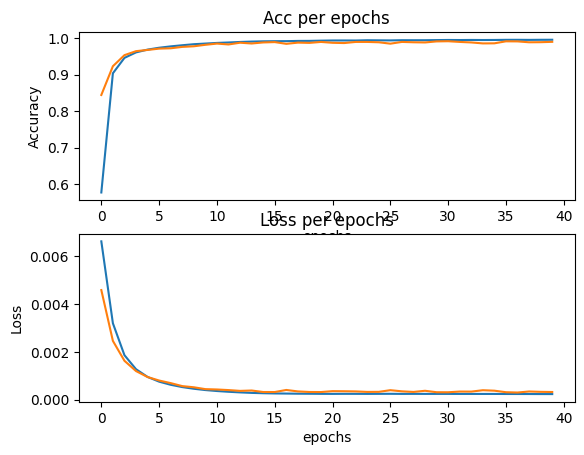

In [17]:
acc_list= []
valid_acc_list= []

loss_list= []
valid_loss_list= []

model.zero_grad()
for epoch in range(num_epochs):
    model.train()
    train_acc= 0.0
    train_loss= 0.0
    
    valid_loss = 0.0
    valid_acc = 0.0
    
    for imgs, labels in tqdm(train_loader):
        output = model(imgs)
        output_label = output.argmax(dim=1)
        loss = loss_fn(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss+= loss.item()
        train_acc+= (output_label == labels).sum().item()
    
    train_loss/= len(train_dataset)
    train_acc/= len(train_dataset)
    loss_list.append(train_loss)
    acc_list.append(train_acc)
    
    #validation
    model.eval()
    for imgs, labels in tqdm(valid_loader):
        output = model(imgs)
        output_label = output.argmax(dim=1)
        loss = loss_fn(output, labels)
        
        valid_loss+= loss.item()
        valid_acc+= (output_label == labels).sum().item()
    
    valid_loss/= len(valid_dataset)
    valid_acc/= len(valid_dataset)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    
    print(f"epoch:{epoch + 1}")
    print(f"train_loss: {train_loss}, train_acc: {train_acc}")
    print(f"valid_loss: {valid_loss}, valid_acc: {valid_acc}")

plt.subplot(211)
plt.title('Acc per epochs')
plt.plot(acc_list)
plt.plot(valid_acc_list)
plt.xlabel('epochs')
plt.ylabel('Accuracy')

plt.subplot(212)
plt.title('Loss per epochs')
plt.plot(loss_list)
plt.plot(valid_loss_list)
plt.xlabel('epochs')
plt.ylabel('Loss')

In [18]:
model.eval()

for test_imgs in test_loader:
    pred = model(test_imgs[0])
    pred_label = pred.argmax(dim=1)

pred_label

tensor([2, 0, 9,  ..., 3, 9, 2])

In [19]:
submission = pd.read_csv(args['submission'])
submission['Label'] = pred_label
submission.to_csv('submission.csv',index=False)

In [20]:
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


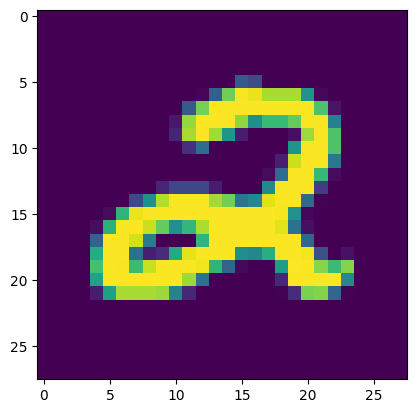

In [21]:
for item in test_loader:
    plt.imshow(item[0][27999])